In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

UsageError: Cell magic `%%shell` not found.


In [66]:
import os
import pandas as pd
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class DeskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.df = pd.read_csv("annotations.csv", names=["class", "xmin", "ymin", "xdist", "ydist", "image", "imgx", "imgy"])
        unique_classes = list(self.df['class'].unique())
        self.class_names = {unique_classes[i]: np.arange(1, 1 + len(unique_classes))[i] for i in range(len(unique_classes))}
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        features = self.df[self.df['image'] == self.imgs[idx]] 
        boxes = []
        labels = []
        for index, row in features.iterrows():
            xmin = row['xmin']
            xmax = row['xmin'] + row['xdist']
            ymin = row['ymin']
            ymax = row['ymin'] + row['ydist']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_names[row['class']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        num_objs = len(boxes)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

ds = DeskDataset(".")

In [67]:
print(len(ds.imgs))
print(len(ds.class_names))

48
4


In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_object_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [10]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
# use our dataset and defined transformations
dataset = DeskDataset('.', get_transform(train=True))
dataset_test = DeskDataset('.', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-44])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-4:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1 + len(ds.class_names)

# get the model using our helper function
model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [69]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/2]  eta: 0:00:02  lr: 0.005000  loss: 2.1679 (2.1679)  loss_classifier: 1.7668 (1.7668)  loss_box_reg: 0.3678 (0.3678)  loss_objectness: 0.0231 (0.0231)  loss_rpn_box_reg: 0.0102 (0.0102)  time: 1.1528  data: 0.5070  max mem: 2895
Epoch: [0]  [1/2]  eta: 0:00:00  lr: 0.005000  loss: 2.1679 (2.2928)  loss_classifier: 1.7668 (1.7776)  loss_box_reg: 0.3678 (0.4688)  loss_objectness: 0.0231 (0.0263)  loss_rpn_box_reg: 0.0102 (0.0202)  time: 0.8431  data: 0.2548  max mem: 2895
Epoch: [0] Total time: 0:00:01 (0.8908 s / it)
Epoch: [1]  [0/2]  eta: 0:00:01  lr: 0.005000  loss: 0.7631 (0.7631)  loss_classifier: 0.4019 (0.4019)  loss_box_reg: 0.3482 (0.3482)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 0.8954  data: 0.3033  max mem: 2895
Epoch: [1]  [1/2]  eta: 0:00:00  lr: 0.005000  loss: 0.7631 (1.0031)  loss_classifier: 0.4019 (0.5461)  loss_box_reg: 0.3482 (0.4379)  loss_objectness: 0.0045 (0.0059)  loss_rpn_box_reg: 0.0057 (0.0132)  time: 0.718

In [62]:
!ls

annotations.csv  deleted    master_label.txt  utils.py
coco_eval.py	 engine.py  __pycache__       vision
coco_utils.py	 images     transforms.py


In [126]:
from torchvision import transforms
# pick one image from the test set
# img, _ = dataset[1]
# print(type(img))
t = Image.open("kevin.png").convert("RGB")
img = transforms.ToTensor()(t).squeeze()
# print(type(img))

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [110]:
prediction

[{'boxes': tensor([[1.1851e+02, 2.7874e+01, 3.9851e+02, 2.7946e+02],
          [1.1999e+02, 5.1475e+01, 3.7043e+02, 2.3174e+02],
          [1.2677e+02, 4.7700e+01, 3.6878e+02, 2.3048e+02],
          [1.2921e+02, 4.5627e+01, 3.6576e+02, 2.3885e+02],
          [2.0333e+02, 1.8352e+01, 3.5670e+02, 2.3632e+02],
          [2.1661e+02, 6.3140e+01, 4.0770e+02, 2.4660e+02],
          [4.0659e-01, 1.7391e+02, 9.8105e+01, 3.6214e+02],
          [1.6551e+02, 6.6338e+01, 4.7400e+02, 2.6335e+02],
          [6.8700e+01, 4.5660e+01, 2.8690e+02, 2.5996e+02],
          [2.1173e+01, 1.8483e+02, 1.0345e+02, 3.1657e+02],
          [0.0000e+00, 1.7965e+02, 1.0296e+02, 3.5347e+02],
          [1.7477e+02, 6.4926e+01, 4.6881e+02, 2.7402e+02],
          [8.6543e+01, 0.0000e+00, 3.1633e+02, 2.8525e+02],
          [1.1402e+02, 6.6494e+01, 3.1918e+02, 2.0269e+02],
          [2.4246e+02, 6.0983e+01, 3.8704e+02, 2.9830e+02],
          [1.6649e+01, 3.7391e+02, 3.2136e+02, 4.6241e+02],
          [2.4784e+01, 1.8114e+

{'monitor': 1, 'keyboard': 2, 'desktop': 3, 'plant': 4}


<Figure size 432x288 with 0 Axes>

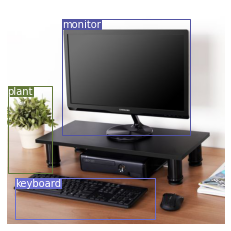

In [124]:
import matplotlib
import matplotlib.pyplot as plt

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.figure()
figure, ax = plt.subplots(1)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
labels = {1: 'monitor', 2: 'keyboard', 3: 'desktop', 4: 'plant'}

for idx, (box, score, class_name) in enumerate(zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels'])):
  if idx in [0, 6, 15]:
    x, y = box[0], box[1]
    len_x, len_y = box[2] - box[0], box[3] - box[1]
    rect = matplotlib.patches.Rectangle((x, y), len_x, len_y, edgecolor=colors[int(class_name.cpu().numpy())], facecolor="none")
    ax.add_patch(rect)
    plt.text(x, y, s=labels[int(class_name.cpu().numpy())], color='white', verticalalignment='top',
                bbox={'color': colors[int(class_name.cpu().numpy())], 'pad': 0})

print(ds.class_names)
ax.imshow(image)
plt.axis('off')
plt.savefig("training_result")

{'monitor': 1, 'keyboard': 2, 'desktop': 3, 'plant': 4}


<Figure size 432x288 with 0 Axes>

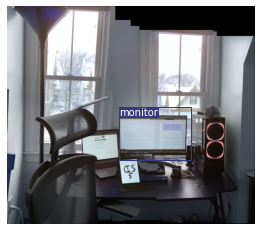

In [127]:
import matplotlib
import matplotlib.pyplot as plt

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.figure()
figure, ax = plt.subplots(1)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

for box, score, class_name in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
  if score > 0.07:
    x, y = box[0], box[1]
    len_x, len_y = box[2] - box[0], box[3] - box[1]
    rect = matplotlib.patches.Rectangle((x, y), len_x, len_y, edgecolor=colors[0], facecolor="none")
    ax.add_patch(rect)
    plt.text(x, y, s="monitor", color='white', verticalalignment='top',
                bbox={'color': colors[0], 'pad': 0})

print(ds.class_names)
ax.imshow(image)
plt.axis('off')
plt.savefig("object_detection_result")

In [54]:
print(ds.class_names)

{'monitor': 1, 'keyboard': 2, 'desktop': 3, 'plant': 4}
